## Baseline Sentiment Analysis Prototype

In [25]:
# Import necessary libraries
import pandas as pd
import numpy as np
import pickle
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix
from sklearn.linear_model import LinearRegression

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Download required NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Henry\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Henry\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Data Loading and Initial Cleaning


Loads the **Amazon Fine Food Reviews** dataset, selects only the relevant columns (`'Text'` and `'Score'`), and removes any rows where the `'Text'` field is missing to ensure clean data for processing.

In [5]:
# Load and clean dataset
data = pd.read_csv('amazon_fine_food_reviews.csv')
data = data[['Text', 'Score']]
data.dropna(subset=['Text'], inplace=True)

### Exploratory Data Analysis (EDA)

Provides an initial overview of the dataset by displaying the distribution of review scores and identifying any missing values in the dataset.

In [8]:
# Display basic insights
print("Class Distribution:\n", data['Score'].value_counts())
print("\nMissing Values:\n", data.isnull().sum())

Class Distribution:
 Score
5    363122
4     80655
1     52268
3     42640
2     29769
Name: count, dtype: int64

Missing Values:
 Text     0
Score    0
dtype: int64


### Soft Label Assignment for Sentiment

Converts the original review scores into soft sentiment labels by assigning a random value within specific ranges, ensuring variation and better representation of sentiment uncertainty.

In [11]:
def assign_soft_label(score):
    if score <= 2:
        return np.random.uniform(0.05, 0.3)
    elif score == 3:
        return np.random.uniform(0.45, 0.55)
    else:
        return np.random.uniform(0.7, 0.95)

data['Sentiment'] = data['Score'].apply(assign_soft_label)

### Text Preprocessing for Sentiment Analysis

Converts text to lowercase, handles negations, removes special characters, removes stop words (except key negations), and lemmatizes the remaining words to prepare the text for model training.

In [14]:
# Initialize lemmatizer and stop words (excluding negations)
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english')) - {'not', 'no', 'nor', 'never'} 

# Text preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"\b(can't|won't|isn't|aren't|wasn't|weren't|don't|doesn't|didn't|hasn't|haven't|hadn't|shouldn't|wouldn't|couldn't|mustn't|n't)\b", "not", text)
    text = ''.join([char for char in text if char.isalnum() or char.isspace()])
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

data['Cleaned_Text'] = data['Text'].apply(preprocess_text)

### Text Vectorization using TF-IDF

Vectorizes the cleaned review texts into TF-IDF features using unigrams and bigrams (up to 3000), saves the vectorizer for future use, and splits the dataset into training and testing sets.

In [17]:
# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=3000, ngram_range=(1, 2))
x = vectorizer.fit_transform(data['Cleaned_Text']).toarray().astype('float32')
y = data['Sentiment']

# Save vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=101)

### Defining the Deep Learning Model Architecture

Builds and compiles a deep learning model using the Keras Sequential API with Dense layers, LeakyReLU activations, dropout for regularization, and a linear output layer to predict soft sentiment scores.

In [20]:
# Build model
def create_model():
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(128, kernel_regularizer=l2(0.001)),
        LeakyReLU(alpha=0.1),
        Dropout(0.3),
        Dense(64, kernel_regularizer=l2(0.001)),
        LeakyReLU(alpha=0.1),
        Dropout(0.3),
        Dense(1, activation='linear')  # Soft sentiment prediction
    ])
    model.compile(optimizer='adam', loss=tf.keras.losses.Huber(), metrics=['mse'])
    return model

### Implementing 5-Fold Cross-Validation for Model Evaluation

Performs 5-fold cross-validation to train and validate the model on different subsets of the training data, recording the Mean Squared Error (MSE) for each fold to evaluate model consistency and calculate the average MSE across all folds.

In [27]:
# Cross-validation (5-fold) to evaluate model stability
kf = KFold(n_splits=5, shuffle=True, random_state=101)
mse_scores = []

for train_idx, val_idx in kf.split(X_train):
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = create_model()
    model.fit(X_tr, y_tr, validation_data=(X_val, y_val), epochs=5, batch_size=512, verbose=0)
    mse = model.evaluate(X_val, y_val, verbose=0)[1]
    mse_scores.append(mse)

print("Cross-Validation MSE Scores:", mse_scores)
print("Average MSE:", np.mean(mse_scores))

C:\Users\Henry\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
C:\Users\Henry\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
C:\Users\Henry\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
C:\Users\Henry\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
C:\Users\Henry\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Cross-Validation MSE Scores: [0.03182036057114601, 0.032730091363191605, 0.03208787739276886, 0.033355798572301865, 0.03157788887619972]
Average MSE: 0.03231440335512161


### Training and Saving the Final Model

Trains the final model on the entire training dataset with 10% reserved for validation, running for 20 epochs, and then saves the trained model to a file named `sentiment_model.h5` for future use.

In [30]:
# Final training with early stopping
final_model = create_model()
history = final_model.fit(X_train, y_train, 
                          epochs=20, 
                          batch_size=512, 
                          validation_split=0.1,
                          callbacks=[EarlyStopping(patience=5, restore_best_weights=True)], 
                          verbose=1)

# Save the final model
final_model.save('sentiment_model.h5')
print("Final Model saved successfully!")

C:\Users\Henry\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0979 - mse: 0.0784 - val_loss: 0.0238 - val_mse: 0.0371
Epoch 2/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0261 - mse: 0.0417 - val_loss: 0.0223 - val_mse: 0.0347
Epoch 3/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0241 - mse: 0.0386 - val_loss: 0.0214 - val_mse: 0.0335
Epoch 4/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0232 - mse: 0.0374 - val_loss: 0.0208 - val_mse: 0.0327
Epoch 5/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0224 - mse: 0.0362 - val_loss: 0.0199 - val_mse: 0.0317
Epoch 6/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0215 - mse: 0.0352 - val_loss: 0.0192 - val_mse: 0.0310
Epoch 7/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0210 - mse: 0.0347 - val_loss: 0.0188 - val_mse: 0.0308
Epoch 8/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0206 - mse: 0.0342 - val_loss: 0.0184 - val_mse: 0.0302
Epoch 9/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step 

Final Model saved successfully!


### Visualizing Training and Validation Loss Over Epochs

Plots the training and validation loss values across each epoch to visually analyze the model's learning progress and check for issues like overfitting or underfitting.

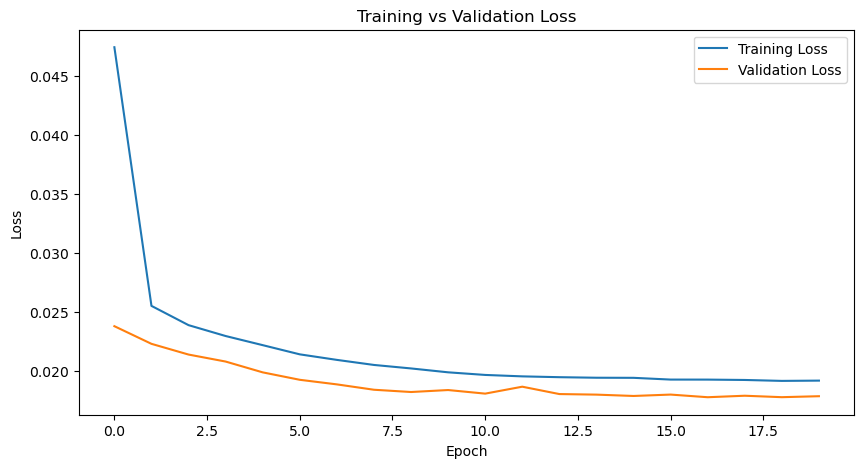

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Evaluating the Final Model on Test Set

Generates sentiment score predictions for the test set using the trained model, calculates the Mean Squared Error (MSE) between the predicted and actual values, and prints the test set MSE as a performance metric.

In [36]:
predictions = final_model.predict(X_test).flatten()
test_mse = mean_squared_error(y_test, predictions)
print("Test Set MSE:", test_mse)

3553/3553 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
Test Set MSE: 0.030224363742019054


###  Mapping Soft Predictions to Sentiment Labels

Converts continuous sentiment scores into categorical labels (`'Positive`', `'Neutral`', `'Negative`') based on defined thresholds, and then evaluates the model's classification performance using a classification report.

In [39]:
# Map continuous predictions to categorical labels
def classify_sentiment(score):
    if score >= 0.7:
        return 'Positive'
    elif score < 0.4:
        return 'Negative'
    else:
        return 'Neutral'

predicted_labels = [classify_sentiment(p) for p in predictions]
true_labels = [classify_sentiment(t) for t in y_test]

# Classification report and confusion matrix
print("\nClassification Report:\n", classification_report(true_labels, predicted_labels))


Classification Report:
               precision    recall  f1-score   support

    Negative       0.80      0.46      0.58     16329
     Neutral       0.19      0.51      0.28      8600
    Positive       0.94      0.86      0.90     88762

    accuracy                           0.78    113691
   macro avg       0.64      0.61      0.59    113691
weighted avg       0.87      0.78      0.81    113691



### Visualizing the Confusion Matrix

Generates and visualizes the confusion matrix to show how well the model's predicted sentiment categories align with the true sentiment labels, helping identify classification accuracy and common misclassifications.

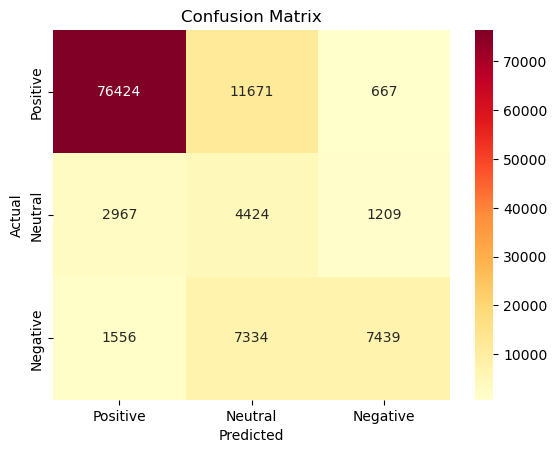

In [42]:
cm = confusion_matrix(true_labels, predicted_labels, labels=['Positive', 'Neutral', 'Negative'])
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd', xticklabels=['Positive', 'Neutral', 'Negative'], yticklabels=['Positive', 'Neutral', 'Negative'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Baseline Model Comparison

Creates a baseline model that predicts the mean sentiment score from the training data for all test samples, calculates its MSE, and compares it to the trained model's MSE to assess improvement over a common-sense baseline.

In [45]:
# Compare to baseline (mean predictor)
baseline_prediction = np.full_like(y_test, y_train.mean())
baseline_mse = mean_squared_error(y_test, baseline_prediction)

print(f"\nBaseline Mean Predictor MSE: {baseline_mse:.4f}")
print(f"Your Model MSE: {mse:.4f}")


Baseline Mean Predictor MSE: 0.0596
Your Model MSE: 0.0316


### Linear Regression Benchmark

Trains a basic Linear Regression model on the training data and evaluates its performance on the test set by computing the Mean Squared Error (MSE), providing a benchmark for comparison against the deep learning model.

In [48]:
# Compare to Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

lr_mse = mean_squared_error(y_test, lr_preds)
print(f"\nLinear Regression MSE: {lr_mse:.4f}")


Linear Regression MSE: 0.0322


### Example Predictions Overview

Prints the first five reviews from the dataset along with their true soft sentiment scores and the model’s predicted sentiment values to qualitatively assess prediction accuracy.

In [51]:
# Display a few prediction examples
for i in range(5):
    print("\nReview:", data['Text'].iloc[i][:200])
    print("True Sentiment:", round(y_test.iloc[i], 2))
    print("Predicted:", round(predictions[i], 2))



Review: I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador
True Sentiment: 0.12
Predicted: 0.53

Review: Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
True Sentiment: 0.95
Predicted: 0.56

Review: This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powd
True Sentiment: 0.91
Predicted: 0.8

Review: If you are looking for the secret ingredient in Robitussin I believe I have found it.  I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda.  The flavor
True Sentiment: 0.9
Predicted: 0.8

Review: Great taffy at a